# Trabalho final - Análise da Play Store: qual será o proxímo grande app?

Dataset extraído de:

* https://www.kaggle.com/datasets/lava18/google-play-store-apps

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import graphviz

from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from lime import lime_tabular

from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1 - Analisando a Estrutura do Dataset

Desenvolver um modelo preditivo para identificar os elementos determinantes do sucesso de um aplicativo em lojas digitais apresenta desafios multifacetados e cruciais. A complexidade reside na vasta gama de variáveis que influenciam a aceitação e o desempenho de um aplicativo, desde características técnicas até preferências do usuário. Compreender como atributos como engajamneto dos usuários, estratégias de monetização e análise de feedback influenciam a popularidade e a adoção de um aplicativo é essencial para construir um modelo preditivo.

O foco deste trabalho é compreender o comportamento real de aplicativos e como levam ao sucesso em lojas dedicadas e tentar determinar elementos quantificáveis que tragam sucesso.

In [ ]:
#Extraindo os dados do dataset original e analisando os elementos iniciais
df = pd.read_csv('/content/drive/MyDrive/docs/googleplaystore.csv')
print(df.head())

                                                 App        Category  Rating  \
0     Photo Editor & Candy Camera & Grid & ScrapBook  ART_AND_DESIGN     4.1   
1                                Coloring book moana  ART_AND_DESIGN     3.9   
2  U Launcher Lite – FREE Live Cool Themes, Hide ...  ART_AND_DESIGN     4.7   
3                              Sketch - Draw & Paint  ART_AND_DESIGN     4.5   
4              Pixel Draw - Number Art Coloring Book  ART_AND_DESIGN     4.3   

  Reviews  Size     Installs  Type Price Content Rating  \
0     159   19M      10,000+  Free     0       Everyone   
1     967   14M     500,000+  Free     0       Everyone   
2   87510  8.7M   5,000,000+  Free     0       Everyone   
3  215644   25M  50,000,000+  Free     0           Teen   
4     967  2.8M     100,000+  Free     0       Everyone   

                      Genres      Last Updated         Current Ver  \
0               Art & Design   January 7, 2018               1.0.0   
1  Art & Design;Pretend 

In [ ]:
#Análise da estrutura dos dados
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10841 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             10841 non-null  object 
 1   Category        10841 non-null  object 
 2   Rating          9367 non-null   float64
 3   Reviews         10841 non-null  object 
 4   Size            10841 non-null  object 
 5   Installs        10841 non-null  object 
 6   Type            10840 non-null  object 
 7   Price           10841 non-null  object 
 8   Content Rating  10840 non-null  object 
 9   Genres          10841 non-null  object 
 10  Last Updated    10841 non-null  object 
 11  Current Ver     10833 non-null  object 
 12  Android Ver     10838 non-null  object 
dtypes: float64(1), object(12)
memory usage: 1.1+ MB
None
            Rating
count  9367.000000
mean      4.193338
std       0.537431
min       1.000000
25%       4.000000
50%       4.300000
75%       4.500000
max   

As variáveis do data sente efetivamente são as seguintes:

* App - Nome do aplicativo
* Category - Categoria à qual o aplicativo pertence
* Rating - Classificação geral do aplicativo pelos usuários (como quando foi coletado)
* Reviews - Número de avaliações de usuários para o aplicativo (como quando foi coletado)
* Size - Tamanho do aplicativo (como quando foi coletado)
* Installs - Número de downloads/instalações do aplicativo pelos usuários (como quando foi coletado)
* Type - Pago ou Gratuito
* Price - Preço do aplicativo (como quando foi coletado)
* Content Rating - Faixa etária para a qual o aplicativo é destinada - Crianças / Adultos (21+) / Adulto
* Genres - Um aplicativo pode pertencer a vários gêneros (além de sua categoria principal). Por exemplo, um jogo musical familiar pertencerá
* Last Updated - Última vez que foi atualizado (como quando foi coletado)
* Current Ver - Versão atual (como quando foi coletado)
* Android Ver - Versão do SO suportada (como quando foi coletado)

# 2 - Sanitizando os dados

A sanitização de dados em um dataset é crucial para garantir a qualidade e a confiabilidade das análises e modelos construídos. Este processo envolve identificar e corrigir inconsistências, erros e valores ausentes nos dados, garantindo assim que as conclusões derivadas sejam precisas e não distorcidas por informações incorretas.

Diante disso, tomaremos as devidas medidas para regularizar as variáveis antes de realizarmos análise profunda sob os dados.

In [ ]:
#Removendo os NA presentes no dataset
df = df.dropna()

In [ ]:
# Removendo duplicados
df = df.drop_duplicates()

In [ ]:
# Funções para remover letras de numeros, convertendo string em floats
def convert_size(size):
    if isinstance(size, str):
        if 'M' in size:
            return float(size.replace('M', '')) * 1e6
        elif 'k' in size:
            return float(size.replace('k', '')) * 1e3
        else:
            return np.nan
    return size

def convert_price(price):
    if isinstance(price, str):
        return float(price.replace('$', ''))
    return price


#Aplicando a função de remoção em Installs e price
df['Price'] = df['Price'].apply(convert_price)
df['Installs'] = df['Installs'].str.replace('[+,]', '', regex=True).astype(int)

#Apliando a função de conversão de size, mas como tem opções com texto, converte-se para NA e depois aplica a media aos que ficaram com NA
df['Size'] = df['Size'].replace('Varies with device', np.nan)
df['Size'] = df['Size'].apply(convert_size)
df['Size'] = df['Size'].fillna(df['Size'].median())

#Normalizando a coluna Reviews para int
df['Reviews'] = df['Reviews'].astype(int)

In [ ]:
# Analisando como a estrutura ficou após a normalização
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 8886 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             8886 non-null   object 
 1   Category        8886 non-null   object 
 2   Rating          8886 non-null   float64
 3   Reviews         8886 non-null   int64  
 4   Size            8886 non-null   float64
 5   Installs        8886 non-null   int64  
 6   Type            8886 non-null   object 
 7   Price           8886 non-null   float64
 8   Content Rating  8886 non-null   object 
 9   Genres          8886 non-null   object 
 10  Last Updated    8886 non-null   object 
 11  Current Ver     8886 non-null   object 
 12  Android Ver     8886 non-null   object 
dtypes: float64(3), int64(2), object(8)
memory usage: 971.9+ KB
None


# 3 - Descrição dos Dados

Agora que temos os dados consistentes, podemos analisar as variáveis do dataset de maneira robusta, afim de identifcar importantes correlações e relevantes ao problema em tela.

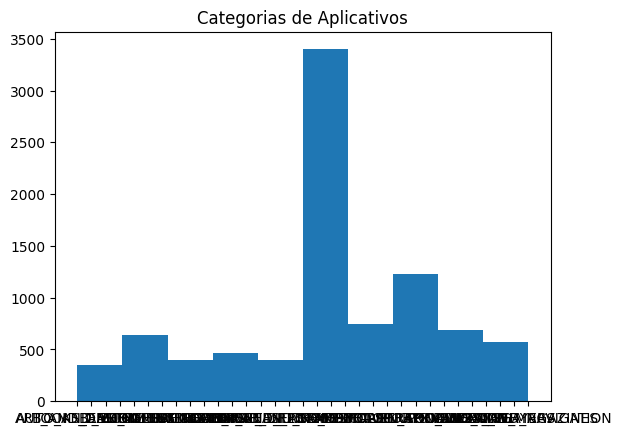

In [ ]:
plt.hist(df['Category'])
plt.title('Categorias de Aplicativos')
plt.show()

In [ ]:
df.groupby('Category').size()

Category
ART_AND_DESIGN           61
AUTO_AND_VEHICLES        73
BEAUTY                   42
BOOKS_AND_REFERENCE     177
BUSINESS                270
COMICS                   58
COMMUNICATION           307
DATING                  159
EDUCATION               129
ENTERTAINMENT           111
EVENTS                   45
FAMILY                 1717
FINANCE                 317
FOOD_AND_DRINK          106
GAME                   1074
HEALTH_AND_FITNESS      262
HOUSE_AND_HOME           68
LIBRARIES_AND_DEMO       64
LIFESTYLE               305
MAPS_AND_NAVIGATION     124
MEDICAL                 302
NEWS_AND_MAGAZINES      214
PARENTING                50
PERSONALIZATION         308
PHOTOGRAPHY             304
PRODUCTIVITY            334
SHOPPING                202
SOCIAL                  244
SPORTS                  286
TOOLS                   733
TRAVEL_AND_LOCAL        205
VIDEO_PLAYERS           160
WEATHER                  75
dtype: int64

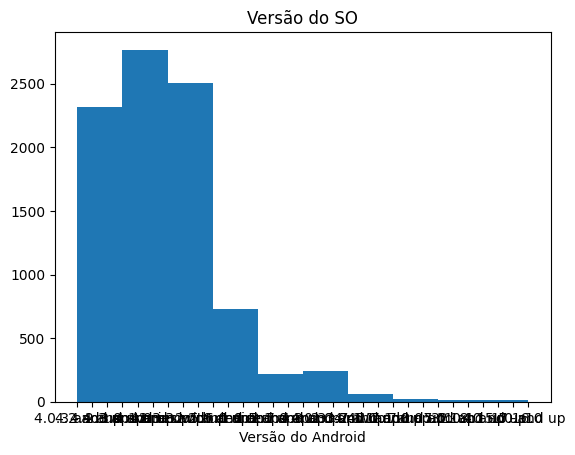

In [ ]:
plt.hist(df['Android Ver'])
plt.xlabel('Versão do Android')
plt.title('Versão do SO')
plt.show()

In [ ]:
df.groupby('Android Ver').size()

Android Ver
1.0 and up               2
1.5 and up              15
1.6 and up              87
2.0 and up              27
2.0.1 and up             7
2.1 and up             112
2.2 and up             203
2.3 and up             573
2.3.3 and up           238
3.0 and up             207
3.1 and up               8
3.2 and up              31
4.0 and up            1092
4.0.3 - 7.1.1            2
4.0.3 and up          1197
4.1 - 7.1.1              1
4.1 and up            1987
4.2 and up             330
4.3 and up             199
4.4 and up             789
4.4W and up              5
5.0 - 6.0                1
5.0 - 8.0                2
5.0 and up             481
5.1 and up              16
6.0 and up              46
7.0 - 7.1.1              1
7.0 and up              41
7.1 and up               3
8.0 and up               5
Varies with device    1178
dtype: int64

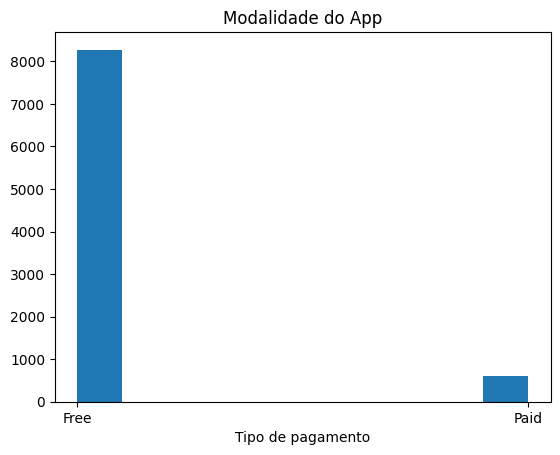

In [ ]:
plt.hist(df['Type'])
plt.xlabel('Tipo de pagamento')
plt.title('Modalidade do App')
plt.show()

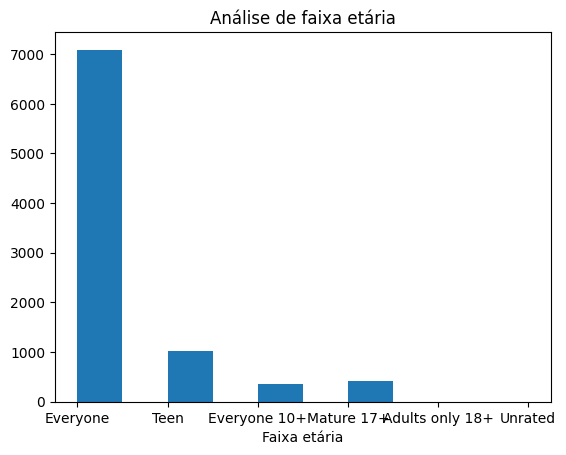

In [ ]:
plt.hist(df['Content Rating'])
plt.xlabel('Faixa etária')
plt.title('Análise de faixa etária')
plt.show()

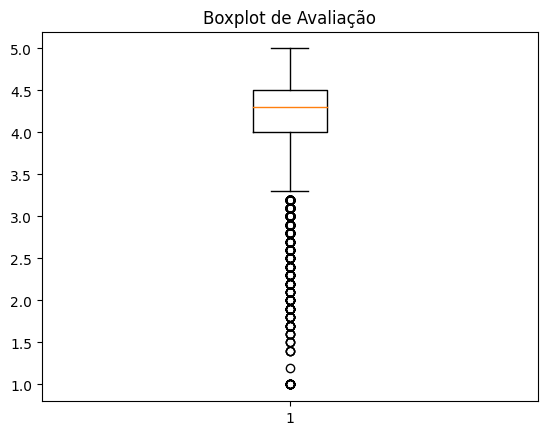

In [ ]:
plt.boxplot(df['Rating'])
plt.title('Boxplot de Avaliação')
plt.show()

In [ ]:
df['Rating'].describe()

count    8886.000000
mean        4.187959
std         0.522428
min         1.000000
25%         4.000000
50%         4.300000
75%         4.500000
max         5.000000
Name: Rating, dtype: float64

Notamos o comportamento preciso em termo de avaliações para determinar o nível de popularidade de um aplicativo, portanto cabe uma analise mais aprofundada de outra variável pertinente nesse assunto, o engajamento com as avaliações (variável 'Review')

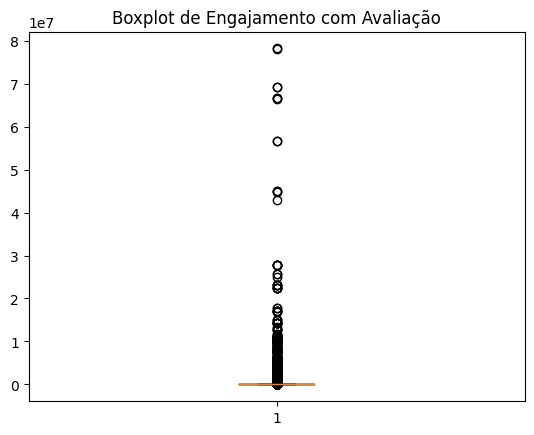

In [ ]:
plt.boxplot(df['Reviews'])
plt.title('Boxplot de Engajamento com Avaliação')
plt.show()

In [ ]:
df['Reviews'].describe()

count    8.886000e+03
mean     4.730928e+05
std      2.906007e+06
min      1.000000e+00
25%      1.640000e+02
50%      4.723000e+03
75%      7.131325e+04
max      7.815831e+07
Name: Reviews, dtype: float64

Há presença de muitos outliers, mas há uma tendência clara concentrando o engajmaneto médio em 5 mil avaliações, logo resultados de pesquisa de aplicativos com esse nivel de engajamento tenderão a refletir a popularidade do app.

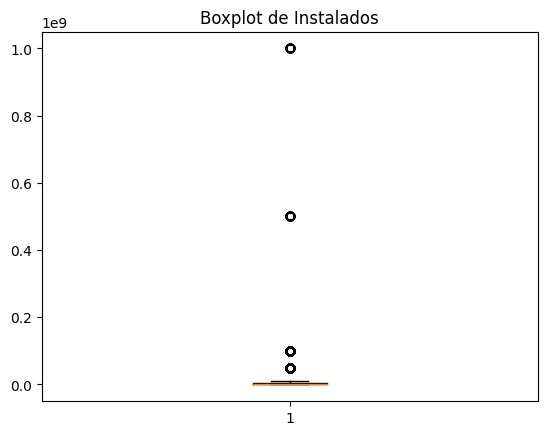

In [ ]:
plt.boxplot(df['Installs'])
plt.title('Boxplot de Instalados')
plt.show()

In [ ]:
df['Installs'].describe()

count    8.886000e+03
mean     1.650061e+07
std      8.640413e+07
min      1.000000e+00
25%      1.000000e+04
50%      5.000000e+05
75%      5.000000e+06
max      1.000000e+09
Name: Installs, dtype: float64

Por fim, a régua de popularidade que é possível mensurar neste dataset que é o quanto o aplicativo foi instalado/baixado. Importante balizar esta popularidade pelo nível de engajamento pelos usuários. O que faremos a seguir.

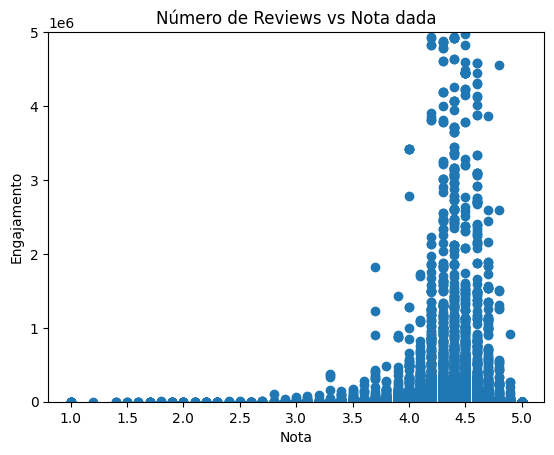

In [ ]:
plt.scatter(df['Rating'],df['Reviews'])
plt.xlabel('Nota')
plt.ylabel('Engajamento')
plt.title('Número de Reviews vs Nota dada')
plt.ylim(0, 0.5*1e7)
plt.show()

A disperção demonstra que os apps mais bem avaliados tendem a ter o maior engajamento por parte dos usuários, logo este é um bom sinalizador de "sucesso" para um app.

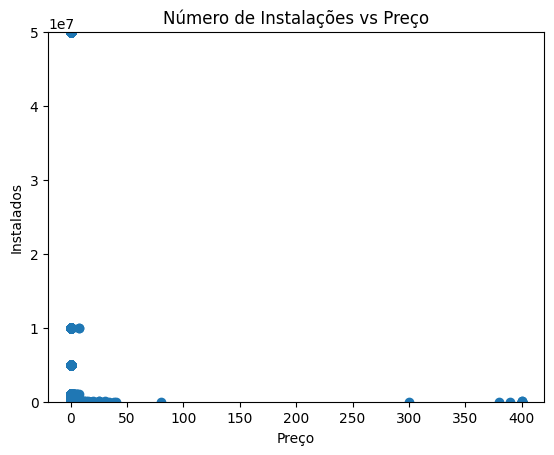

In [ ]:
plt.scatter(df['Price'],df['Installs'])
plt.xlabel('Preço')
plt.ylabel('Instalados')
plt.title('Número de Instalações vs Preço')
plt.ylim(0, 0.5*1e8)
plt.show()

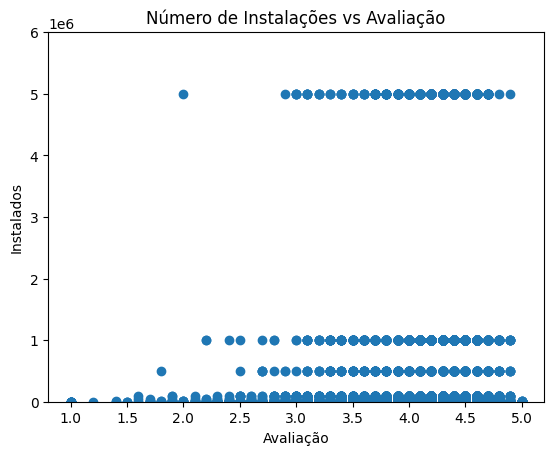

In [ ]:
plt.scatter(df['Rating'],df['Installs'])
plt.xlabel('Avaliação')
plt.ylabel('Instalados')
plt.title('Número de Instalações vs Avaliação')
plt.ylim(0, 0.6*1e7)
plt.show()

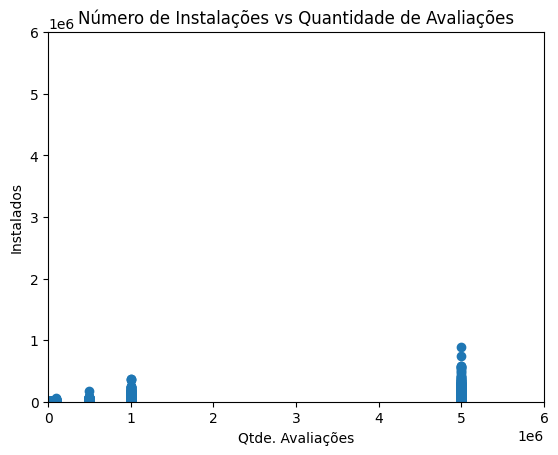

In [ ]:
plt.scatter(df['Installs'], df['Reviews'])
plt.xlabel('Qtde. Avaliações')
plt.ylabel('Instalados')
plt.title('Número de Instalações vs Quantidade de Avaliações')
plt.xlim(0, 0.6*1e7)
plt.ylim(0, 0.6*1e7)
plt.show()

Com os elementos acima demonstrados, fica claro que podemos traçar uma variável indicadora do sucesso de um aplicativo, mensurando apartir pela quantidade de instalações, avalaição e engajamento em feedbacks.

# 4 - Criação de Variável

Delimitado os elementos que constituem o sucesso de um app na Play Store, criamos a variável 'succ' que será definida pelos seguintes critérios:

* Número de instalações superiores a 5000
* Avaliação superior a 4.5 estrelas
* Número de avaliações superior a 5000

Esta variável indicará 1 quando atingir esses patamares e 0 quando não. Os patamares foram escolhidos como base na analise de quartis das variáveis, colocando todos no 3o ou 4o quartil de cada uma.

In [ ]:
df['succ'] = ((df['Installs'] > 5000) & (df['Rating'] > 4.5) & (df['Reviews'] > 5000)).astype('int64')
print(df.head())

                                                 App        Category  Rating  \
0     Photo Editor & Candy Camera & Grid & ScrapBook  ART_AND_DESIGN     4.1   
1                                Coloring book moana  ART_AND_DESIGN     3.9   
2  U Launcher Lite – FREE Live Cool Themes, Hide ...  ART_AND_DESIGN     4.7   
3                              Sketch - Draw & Paint  ART_AND_DESIGN     4.5   
4              Pixel Draw - Number Art Coloring Book  ART_AND_DESIGN     4.3   

   Reviews        Size  Installs  Type  Price Content Rating  \
0      159  19000000.0     10000  Free    0.0       Everyone   
1      967  14000000.0    500000  Free    0.0       Everyone   
2    87510   8700000.0   5000000  Free    0.0       Everyone   
3   215644  25000000.0  50000000  Free    0.0           Teen   
4      967   2800000.0    100000  Free    0.0       Everyone   

                      Genres      Last Updated         Current Ver  \
0               Art & Design   January 7, 2018               1.0

A seguir uma pequena análise da distribuição pautando-se pela avaliação dos aplicativos avaliados como sucesso.

In [ ]:
pd.crosstab(df['succ'], df['Rating'])

Rating,1.0,1.2,1.4,1.5,1.6,1.7,1.8,1.9,2.0,2.1,...,4.1,4.2,4.3,4.4,4.5,4.6,4.7,4.8,4.9,5.0
succ,,,,,,,,,,,,,,,,,,,,,
0,16,1,3,3,4,8,8,12,12,8,...,656,887,1016,1031,976,294,235,145,67,271
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,474,249,83,20,0


# 5 - Elaborando o modelo

Primeiramente iremos escolher as nossas variáveis qualitativas, que determinarão a variável resposta. Aqui é um reflexo dos elementos estudados anteriormente, logo há consideração também dos elementos constitutivos do aplicativo,

In [ ]:
# Selecionando as variáveis qualitativas
df2 = df[['Category', 'Content Rating', 'Type', 'Rating']]
df2.head()

,Category,Content Rating,Type,Rating
0,ART_AND_DESIGN,Everyone,Free,4.1
1,ART_AND_DESIGN,Everyone,Free,3.9
2,ART_AND_DESIGN,Everyone,Free,4.7
3,ART_AND_DESIGN,Teen,Free,4.5
4,ART_AND_DESIGN,Everyone,Free,4.3


Dado o conjunto de variáveis, é feito o passo de inclusão de dummy para poder normalizar as variáveis não numéricas.

In [ ]:
# Adcionando as variáveis dummy para padronizar o estudo
X = pd.get_dummies(df2, drop_first=True)
X.head()

,Rating,Category_AUTO_AND_VEHICLES,Category_BEAUTY,Category_BOOKS_AND_REFERENCE,Category_BUSINESS,Category_COMICS,Category_COMMUNICATION,Category_DATING,Category_EDUCATION,Category_ENTERTAINMENT,...,Category_TOOLS,Category_TRAVEL_AND_LOCAL,Category_VIDEO_PLAYERS,Category_WEATHER,Content Rating_Everyone,Content Rating_Everyone 10+,Content Rating_Mature 17+,Content Rating_Teen,Content Rating_Unrated,Type_Paid
0,4.1,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
1,3.9,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
2,4.7,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
3,4.5,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
4,4.3,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False


In [ ]:
# Determinando a variável resposta
y = df['succ']

In [ ]:
# Separando a base e treinando o algoritmo
X_train, X_test, y_train, y_test = train_test_split(X, y)
clf = tree.DecisionTreeClassifier(max_depth = 3)
clf.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=3)

In [ ]:
#Acurácia em treino
acc = accuracy_score(y_train, clf.predict(X_train))
print(f'A acurácia na base de treino é de: {acc:.10%}')

#Matriz de confusão
pd.crosstab(clf.predict(X_train), y_train)

A acurácia na base de treino é de: 92.0918367347%


succ,0,1
row_0,,
0,6018,506
1,21,119


In [ ]:
#Acurácia em testes
acc = accuracy_score(y_test, clf.predict(X_test))
print(f'A acurácia na base de teste é de: {acc:.10%}')

#Matriz de confusão
pd.crosstab(clf.predict(X_test), y_test)

A acurácia na base de teste é de: 91.9891989199%


succ,0,1
row_0,,
0,2008,165
1,13,36


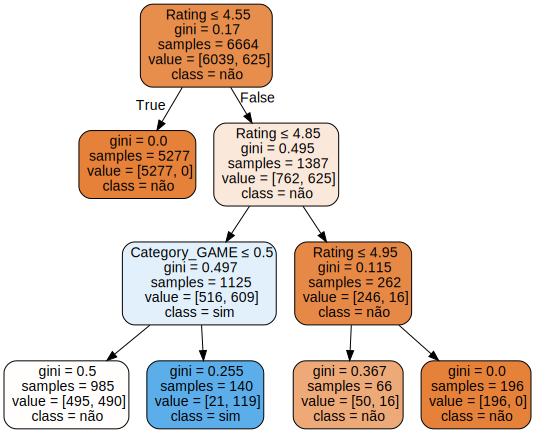

In [ ]:
# Representação da Árvore de decisão
dot_data = tree.export_graphviz(clf, out_file=None,
                     feature_names=X.columns,
                     class_names=['não', 'sim'],
                     filled=True, rounded=True,
                     special_characters=True)
graph = graphviz.Source(dot_data)
graph

In [ ]:
explainer = lime_tabular.LimeTabularExplainer(
    X_train.values,
    feature_names=X.columns,
    class_names=["Insucesso", "Sucesso"])

exp=explainer.explain_instance(X_train.iloc[-1].values, clf.predict_proba)
exp.show_in_notebook()

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


A conclusão do nosso estudo sobre o modelo preditivo evidencia alguns pontos críticos que precisam ser considerados para uma melhor compreensão de seus resultados e implicações. Primeiramente, o modelo alcançou uma acurácia de 90% na base de testes, o que, apesar de ser um valor razoável, ainda indica que há margem para melhorias. Essa performance sugere que o modelo é competente em suas previsões, mas não perfeito, e ainda comete erros em 10% dos casos.

Além disso, é importante destacar a significativa variabilidade entre os elementos da variável predita. Essa variação indica que a distribuição dos dados não é homogênea e que diferentes segmentos da população analisada podem estar influenciando de maneira desigual o desempenho do modelo. Portanto, uma análise mais detalhada sobre a origem dessa variabilidade é essencial para entender se o modelo está capturando todas as nuances dos dados ou se há grupos específicos onde a performance é inferior.

Por fim, é imperativo refletir sobre o objetivo do problema para avaliar se a acurácia alcançada é suficiente. Dependendo do contexto e da aplicação do modelo, uma acurácia de 90% pode ser considerada satisfatória ou insuficiente. Para aplicações críticas, onde erros podem ter consequências severas, esse nível de acurácia pode não ser aceitável. Portanto, é necessário ponderar os requisitos do problema em questão e decidir se o modelo atual atende a essas necessidades ou se são necessárias melhorias adicionais para alcançar um desempenho mais robusto e confiável.

Em resumo, apesar do modelo apresentar uma acurácia de 90%, a variabilidade entre os elementos da variável e a importância do objetivo do problema sugerem que uma análise mais aprofundada e possíveis ajustes são necessários para garantir que o modelo seja verdadeiramente eficaz e adequado para o uso pretendido.